In [1]:
import pandas as pd
from IPython.display import display
import numpy as np

import pathlib as pl
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

%matplotlib inline

from sklearn.cross_decomposition import PLSRegression
from sklearn.datasets import make_regression

In [3]:
X_orig_save,Y_orig_save = make_regression(n_samples=10000,n_features=2,n_targets=1, n_informative=2, noise=1.8)
Y_orig_save = Y_orig_save - Y_orig_save.min()
Y_orig_save = 5*np.pi *Y_orig_save/ Y_orig_save.max()
Y_orig_save = (np.array([np.cos(Y_orig_save), np.sin(Y_orig_save)]) *Y_orig_save ).T
Y_orig_save +=  Y_orig_save/(6*np.pi) *np.random.randn(*Y_orig_save.shape)



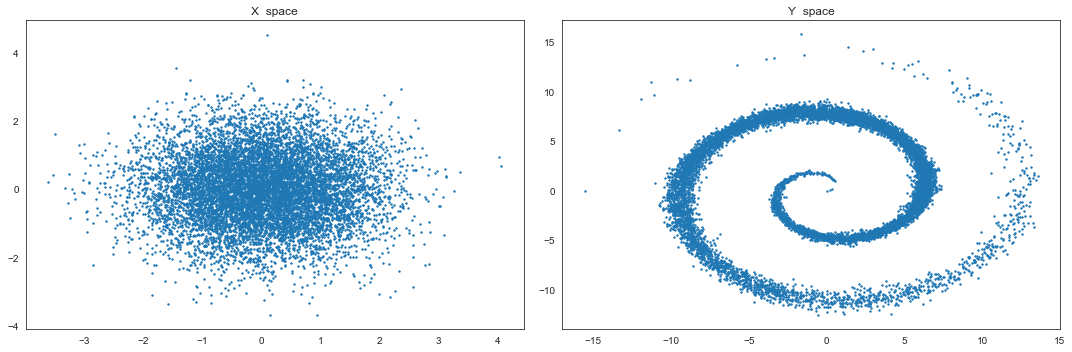

In [26]:

plt.figure(figsize=[15, 5])
X_orig,Y_orig = X_orig_save.copy(),Y_orig_save.copy()
X, Y = X_orig.copy() - X_orig.mean(),Y_orig.copy() - Y_orig.mean()
# plot x space
plt.subplot(121)
plt.scatter(X_orig[:,0],X_orig[:,1], s = 2)
plt.title('X  space')
    


plt.subplot(122)
plt.scatter(Y_orig[:,0],Y_orig[:,1], s = 2)

plt.title('Y  space')
plt.tight_layout()
plt.savefig("./presentation/images/0.png", transparent=True)
plt.show()

# iso

[1. 0.]


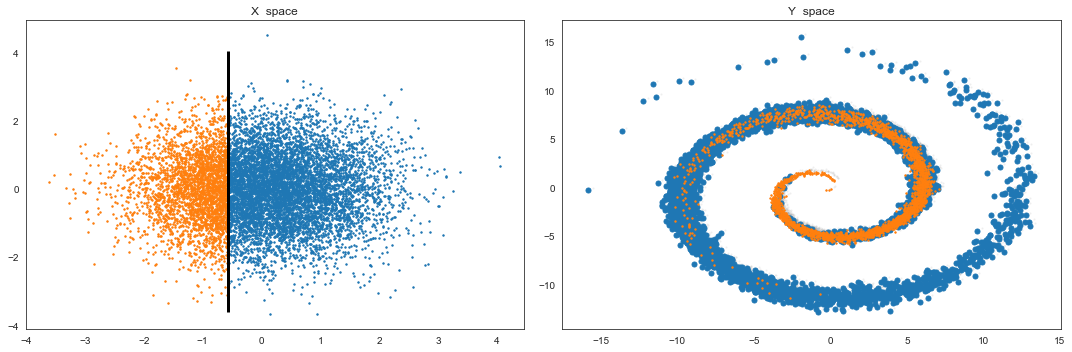

[0. 1.]


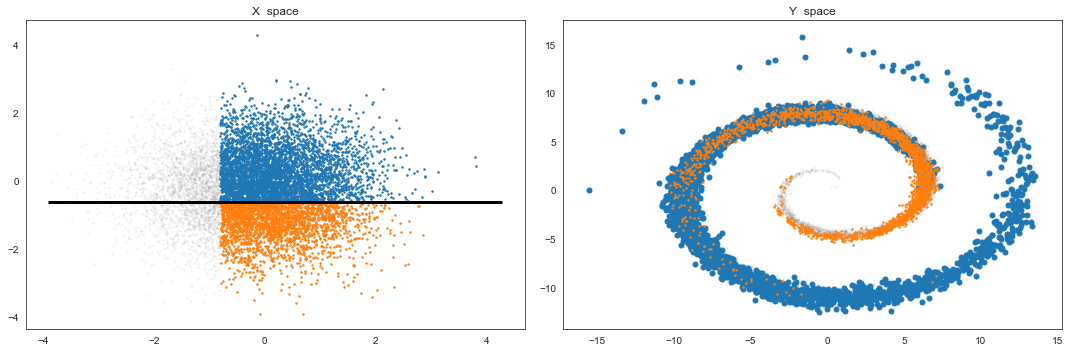

[1. 0.]


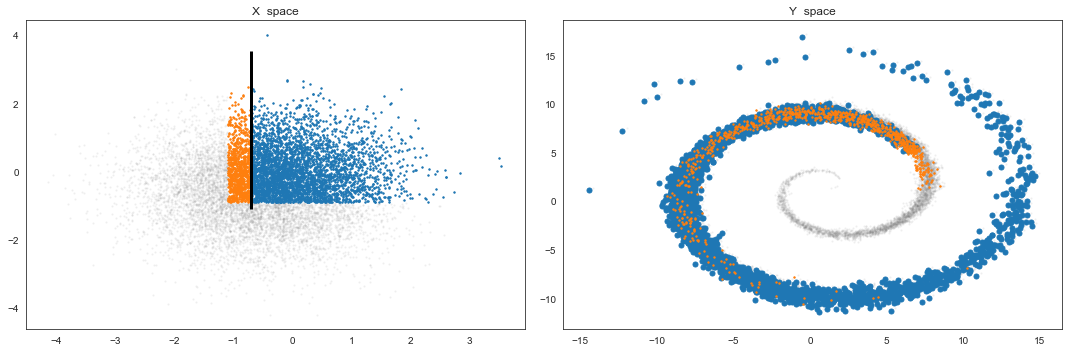

[0. 1.]


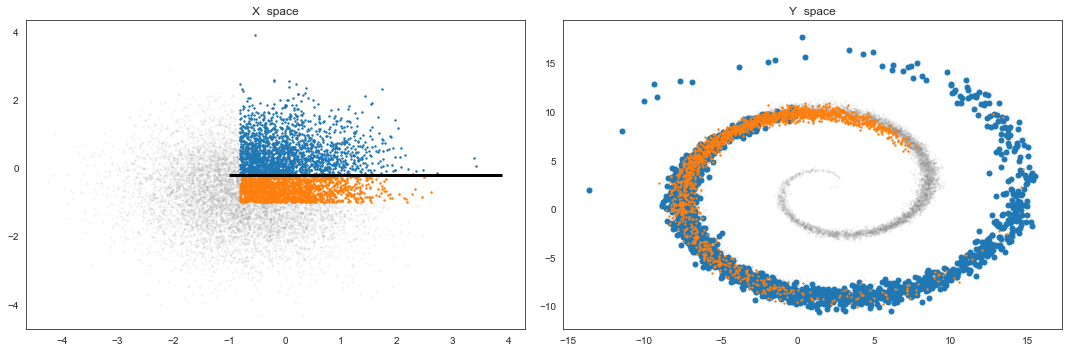

[0. 1.]


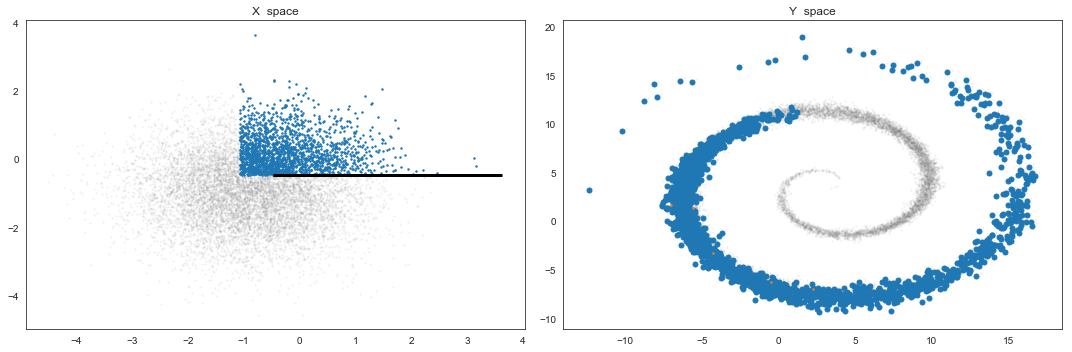

[1. 0.]


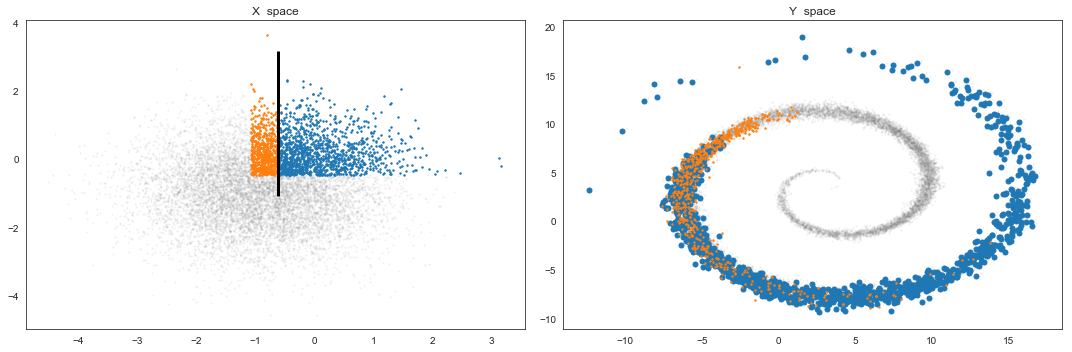

[0. 1.]


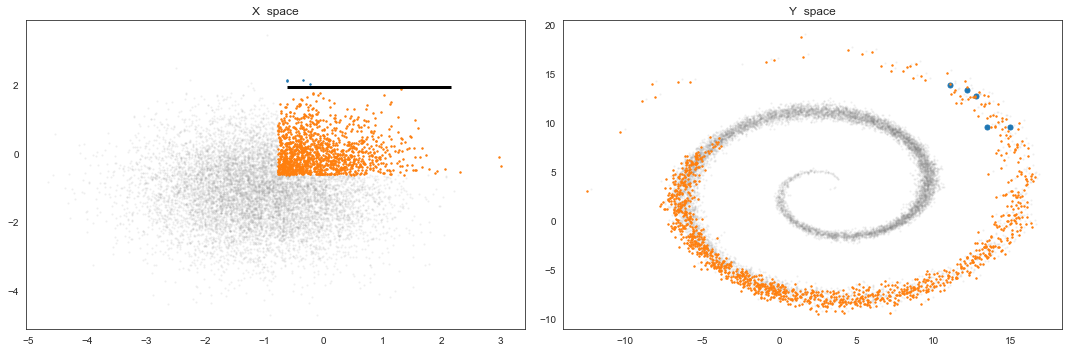

In [27]:
X_orig,Y_orig = X_orig_save.copy(),Y_orig_save.copy()
X, Y = X_orig.copy() - X_orig.mean(),Y_orig.copy() - Y_orig.mean()

acc_mean_x = np.zeros(X.shape[1])
acc_mean_y = np.zeros(Y.shape[1])


i = 0
while X.shape[0] > 100:
    i+=1
    
    sc_cnt = 0
    cnt_min = 0
    min_part_err = np.inf
    next_g = None
    rot = np.zeros((2,)) 
    offset = 0
    
    for f in range(X.shape[1]):
        rot_f = np.zeros((2,))
        rot_f[f] = 1

        x_splits = np.sort(X[:,f].copy())
        x_splits = (x_splits[1:] + x_splits[:-1])/2


        for s in x_splits:
            next_g_tmp = (X[:,f] >= s)
            tmp_cost = np.var(Y[next_g_tmp]) + np.var(Y[np.logical_not(next_g_tmp)])
            tmp_reg = np.log1p(next_g_tmp.size//100) * np.abs(np.log2((1e-5 + Y[next_g_tmp].shape[0])/(1e-5 + Y[np.logical_not(next_g_tmp)].shape[0])))
            if (tmp_cost+tmp_reg) < min_part_err:
                min_part_err = tmp_cost+tmp_reg
                rot = rot_f.copy()
                offset = s
                next_g = next_g_tmp.copy()
                
    print(rot)
                
    plt.figure(figsize=[15, 5])
    
    # plot x space
    plt.subplot(121)
    plt.scatter(X_orig[:,0],X_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(X[next_g,0],X[next_g ,1], s = 2)
    plt.scatter(X[np.logical_not(next_g) ,0],X[np.logical_not(next_g)  ,1], s = 2)
    plt.title('X  space')
    
    #     plot hyper plane 
    if rot[0] == 0:
        plt.hlines(offset,X[:,1].min(),X[:,1].max(), linewidth = 3,colors='k')
    else:
        plt.vlines(offset,X[:,0].min(),X[:,0].max(), linewidth = 3,colors='k')
    

    # plot y space
    # plot y space
    plt.subplot(122)
    plt.scatter(Y_orig[:,0],Y_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(Y[next_g ,0],Y[next_g  ,1], s = 25)
    plt.scatter(Y[np.logical_not(next_g),0],Y[np.logical_not(next_g) ,1], s = 2)
    plt.title('Y  space')
    plt.tight_layout()
    plt.savefig("./presentation/images/iso/{}.png".format(i), transparent=True)
    plt.show()


    # reduce to other hyperplane
    X = X[next_g]
    Y = Y[next_g]
    
    # accomulated shift
    acc_mean_x -= X.mean()
    acc_mean_y -= Y.mean()
    
    # center by mean
    X_orig -= X.mean()
    Y_orig -= Y.mean()
    
    X -= X.mean()
    Y -= Y.mean()

                
        
        
            

# PLS

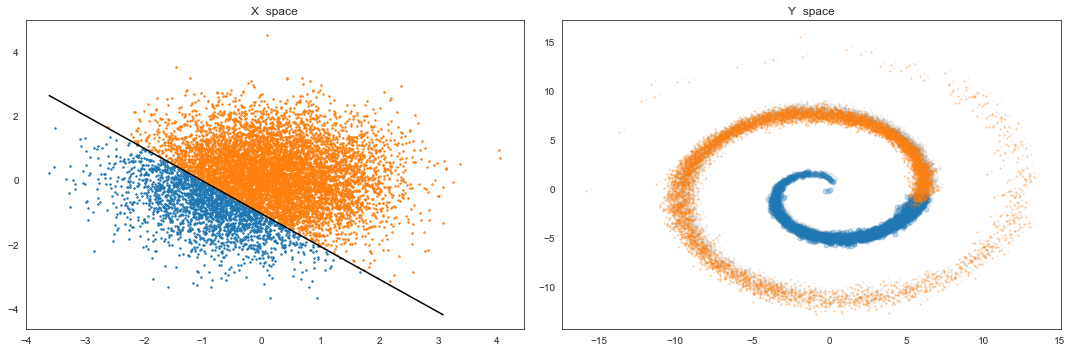

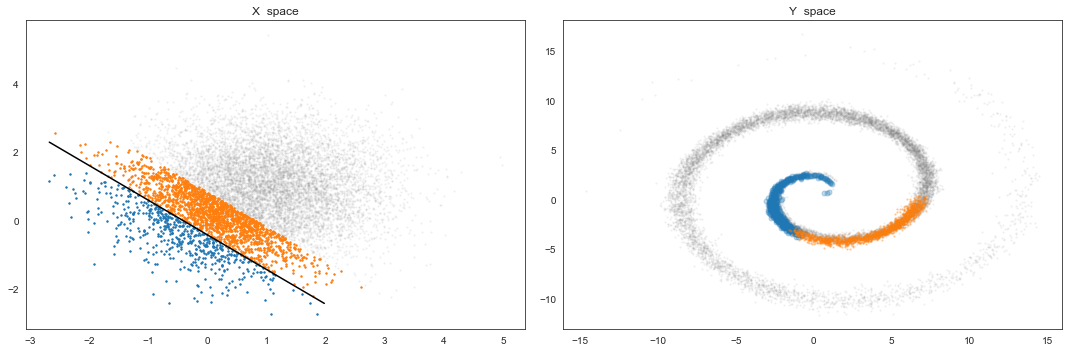

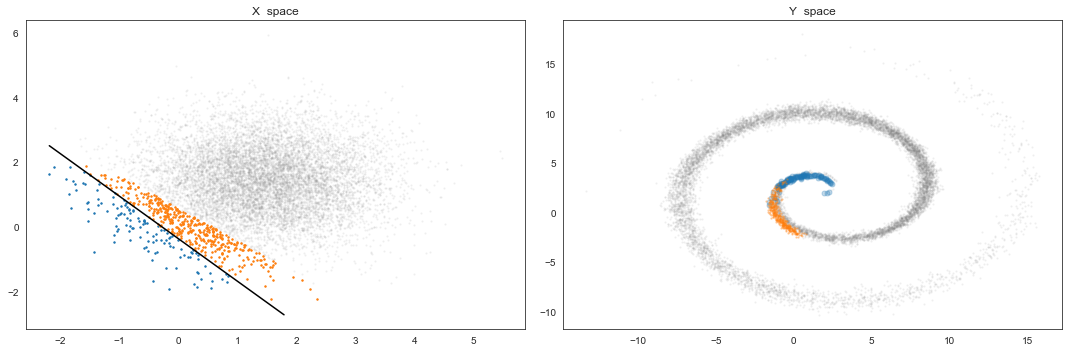

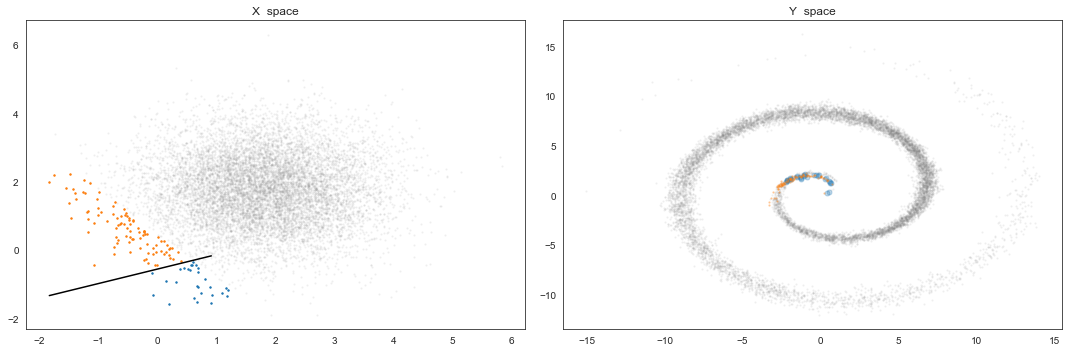

In [30]:
X_orig,Y_orig = X_orig_save.copy(),Y_orig_save.copy()
X, Y = X_orig.copy() - X_orig.mean(),Y_orig.copy() - Y_orig.mean()

acc_mean_x = np.zeros(X.shape[1])
acc_mean_y = np.zeros(Y.shape[1])

pls= PLSRegression(n_components=2)

i = 0
while X.shape[0] > 100:
    i+=1
    
    plsf = pls.fit(X,Y)
    rot=plsf.x_weights_[:,0].T
    
    scores = np.sort(X@rot)
    scores_gaps = (scores[1:] + scores[:-1] )/2
    next_g = (X@rot <= scores_gaps[0])
    sc_cnt = 0
    cnt_min = 0
    part_error = np.abs(np.log2(0.001 +next_g.sum() / (0.001 +np.logical_not(next_g).sum())))
    min_part_err = np.inf
    
    while part_error >1.75 and sc_cnt < scores_gaps.shape[0]:
        
        next_g = (X@rot <= scores_gaps[sc_cnt])
        part_error = np.abs(np.log2(0.0001 +next_g.sum() / (0.0001 +(~next_g).sum())))
        if part_error < min_part_err:
            min_part_err = part_error
            cnt_min = sc_cnt
        sc_cnt +=1
        
    next_g = (X@rot <= scores_gaps[cnt_min])
    

    
    plt.figure(figsize=[15, 5])
    
    # plot x space
    plt.subplot(121)
    plt.scatter(X_orig[:,0],X_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(X[next_g,0],X[next_g ,1], s = 2)
    plt.scatter(X[np.logical_not(next_g) ,0],X[np.logical_not(next_g)  ,1], s = 2)
    plt.title('X  space')
    
    #     plot hyper plane 
    x0, x1 = X[:,0].min(), X[:,0].max()*.76
    y0,y1 = -(x0*rot[0]- scores_gaps[cnt_min])/rot[1] , -(x1*rot[0]- scores_gaps[cnt_min])/rot[1] 
    plt.plot([x0, x1],[y0, y1], 3,c='k')

    # plot y space
    # plot y space
    plt.subplot(122)
    plt.scatter(Y_orig[:,0],Y_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(Y[next_g ,0],Y[next_g  ,1], s = 25,alpha=0.27)
    plt.scatter(Y[np.logical_not(next_g),0],Y[np.logical_not(next_g) ,1], s = 2,alpha=0.27)
    plt.title('Y  space')
    plt.tight_layout()
    plt.savefig("./presentation/images/pls/{}.png".format(i), transparent=True)
    plt.show()


    # reduce to other hyperplane
    X = X[next_g]
    Y = Y[next_g]
    
    # accomulated shift
    acc_mean_x -= X.mean()
    acc_mean_y -= Y.mean()
    
    # center by mean
    X_orig -= X.mean()
    Y_orig -= Y.mean()
    
    X -= X.mean()
    Y -= Y.mean()
    
    
    
    
    


## Charp code to get  ```x_weights_```
```csharp
double[,] fp = pls.Predictors.FactorProportions.ToMatrix().Transpose();
double[,] weights = fp.Transpose().Multiply( pls.Weights.ToMatrix());
```

## 2Means & SVM

(10000, 2)


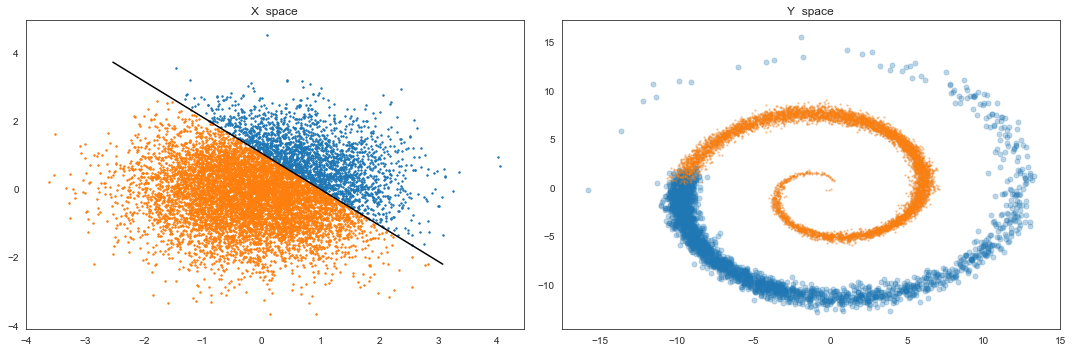

(2292, 2)


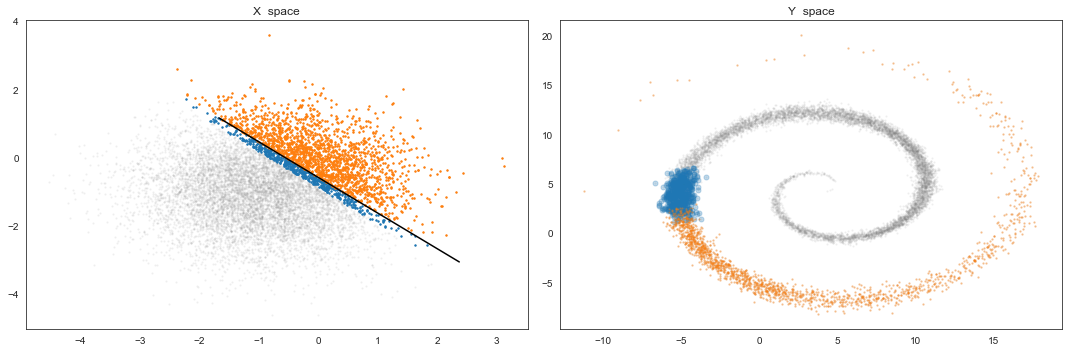

(526, 2)


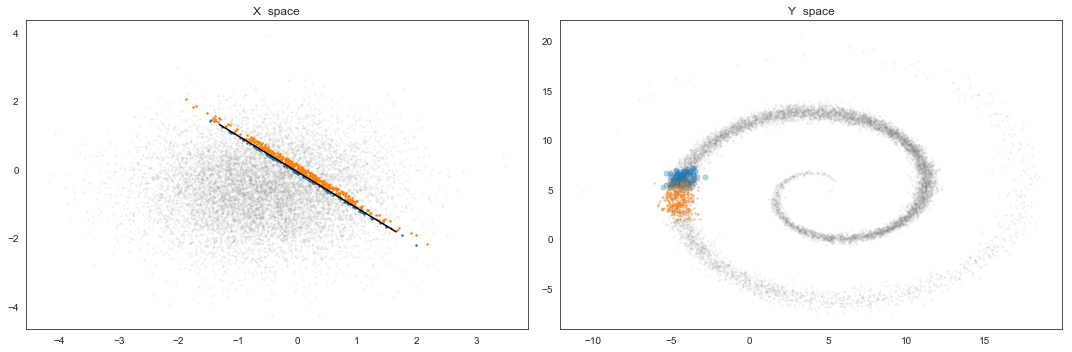

In [32]:
from sklearn.svm import SVC
from sklearn.cluster import KMeans


X_orig,Y_orig = X_orig_save.copy(),Y_orig_save.copy()
X_orig,Y_orig = X_orig- X_orig.mean(),Y_orig- Y_orig.mean()
X, Y = X_orig.copy() ,Y_orig.copy() 

acc_mean_x = np.zeros(X.shape[1])
acc_mean_y = np.zeros(Y.shape[1])

km = KMeans(n_clusters=2, tol=1e-3, max_iter=450,n_init=5,algorithm='full', random_state=1203)
sv= SVC( kernel='linear', max_iter=-1,tol = 1e-3,random_state=10023)

i = 0
while X.shape[0] > 300:
    print(X.shape)
    i+=1
    
    kmf = km.fit(Y)
    labels_X = kmf.predict(Y)

    svf = sv.fit(X, labels_X)
    rot = svf.coef_[0] / np.linalg.norm(svf.coef_[0])
    scores = np.sort(X@rot)
    scores_gaps = (scores[1:] + scores[:-1] )/2
    next_g = (X@rot <= scores_gaps[0])
    sc_cnt = 0
    cnt_min = 0
    part_error = np.abs(np.log2(0.001 +next_g.sum() / (0.001 +np.logical_not(next_g).sum())))
    min_part_err = np.inf
    
    while part_error >1.75 and sc_cnt < scores_gaps.shape[0]:
        
        next_g = (X@rot <= scores_gaps[sc_cnt])
        part_error = np.abs(np.log2(0.0001 +next_g.sum() / (0.0001 +(~next_g).sum())))
        if part_error < min_part_err:
            min_part_err = part_error
            cnt_min = sc_cnt
        sc_cnt +=1
        
    next_g = (X@rot <= scores_gaps[cnt_min])
    
#     next_g = (X@svf.coef_[0] - svf.intercept_[0] <= 0 )
    
    
    plt.figure(figsize=[15, 5])
    
    # plot x space
    plt.subplot(121)
    plt.scatter(X_orig[:,0],X_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(X[next_g,0],X[next_g ,1], s = 2)
    plt.scatter(X[np.logical_not(next_g) ,0],X[np.logical_not(next_g)  ,1], s = 2)
    plt.title('X  space')
    
    #     plot hyper plane 
    x0, x1 = X[:,0].min()*.7, X[:,0].max()*.76
    y0,y1 =  -(x0*rot[0]-scores_gaps[cnt_min])/rot[1] ,  - (x1*rot[0]-scores_gaps[cnt_min])/rot[1]
    plt.plot([x0, x1],[y0, y1], 3,c='k')

    # plot y space
    plt.subplot(122)
    plt.scatter(Y_orig[:,0],Y_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(Y[next_g ,0],Y[next_g  ,1], s = 25,alpha=0.27)
    plt.scatter(Y[np.logical_not(next_g),0],Y[np.logical_not(next_g) ,1], s = 2,alpha=0.27)
    plt.title('Y  space')
    plt.tight_layout()
    plt.savefig("./presentation/images/2Means/{}.png".format(i), transparent=True)
    plt.show()


    # reduce to other hyperplane
    X = X[next_g]
    Y = Y[next_g]
    
    # accomulated shift
    acc_mean_x -=  X.mean()
    acc_mean_y -=  Y.mean()
    
    # center by mean
    X_orig -=  X.mean()
    Y_orig -=  Y.mean()
    
    X -=  X.mean()
    Y -=  Y.mean()

In [322]:
res

 final_simplex: (array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [4.88281250e-07, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00009766e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 4.88281250e-07]]), array([1028.6901877, 1028.6901877, 1028.6901877, 1028.6901877]))
           fun: 1028.6901876995285
       message: 'Optimization terminated successfully.'
          nfev: 49
           nit: 10
        status: 0
       success: True
             x: array([0., 1., 0.])

# PCA

0


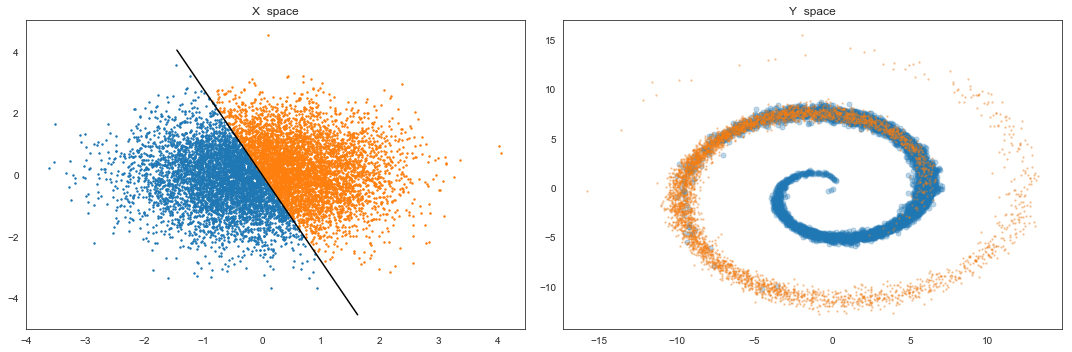

1


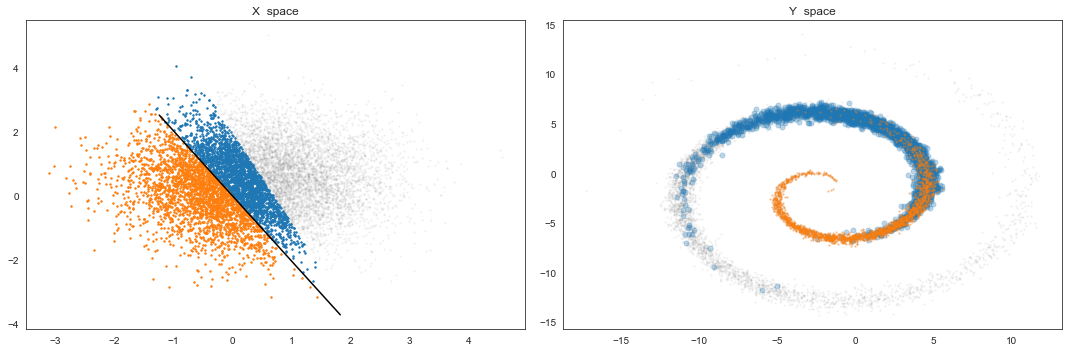

2


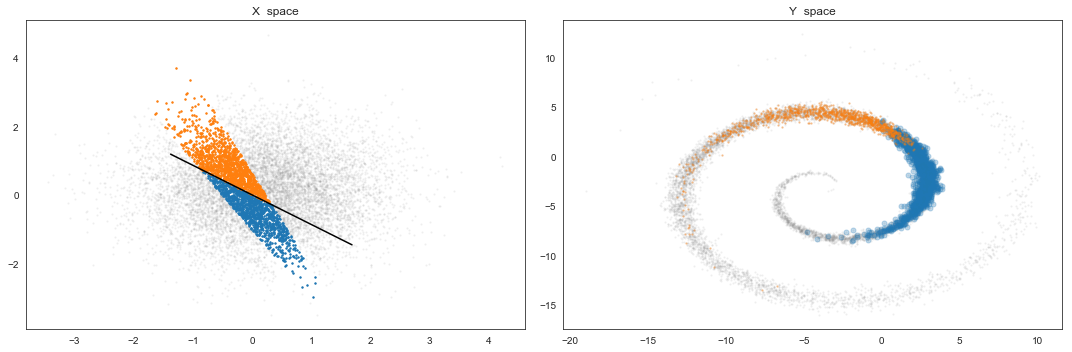

3


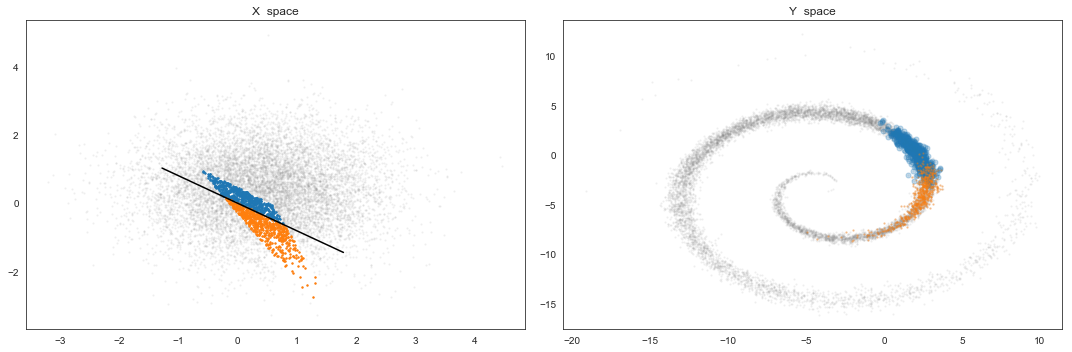

4


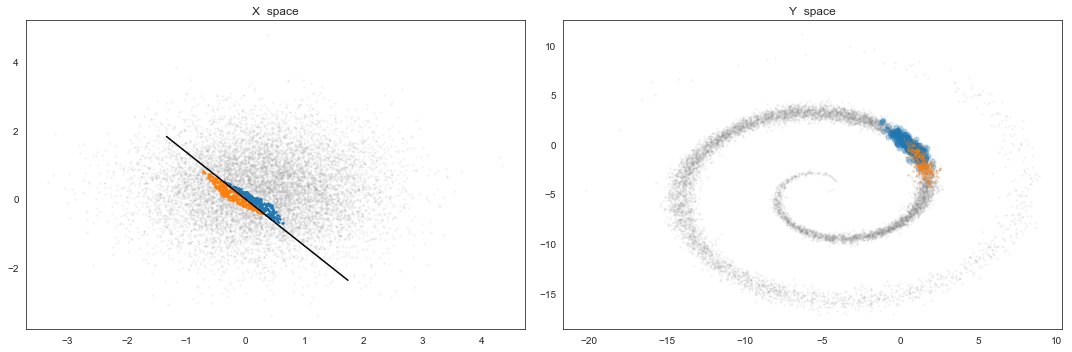

5


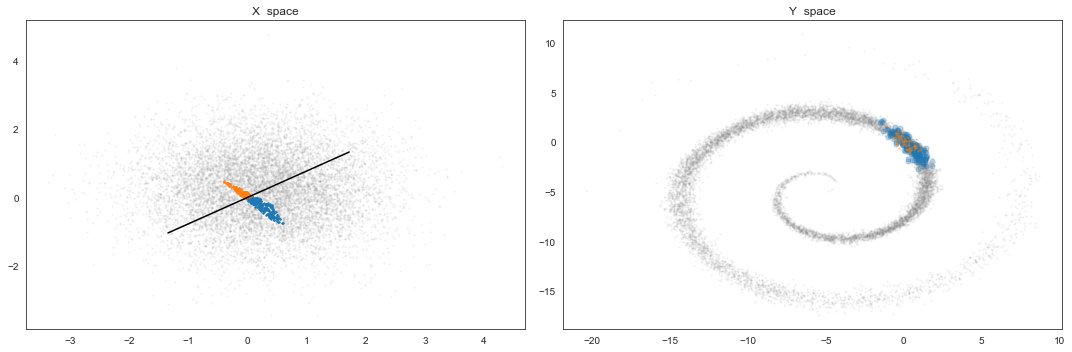

In [38]:
from sklearn.decomposition import PCA
from scipy.optimize import minimize

def var_objective(f_space, r_space, plane_eq):
    bias = plane_eq[-1]
    plane = plane_eq[:-1]
    labels = (f_space@plane <= bias)
    res_A = r_space[labels]
    res_B = r_space[np.logical_not(labels)]
    return np.var(res_A) + np.var(res_A) + max(res_A.shape[0],res_B.shape[0])*np.abs(np.log2( (1e-4 + res_A.shape[0])/(1e-4 + res_B.shape[0]) ))

    

X_orig,Y_orig = X_orig_save.copy(),Y_orig_save.copy()
X_orig,Y_orig = X_orig- X_orig.mean(),Y_orig- Y_orig.mean()
X, Y = X_orig.copy() ,Y_orig.copy() 

acc_mean_x = np.zeros(X.shape[1])
acc_mean_y = np.zeros(Y.shape[1])

pca = PCA(n_components=2)

i = 0
while X.shape[0] > 300:
    print(i)
    i+=1
    
    pcaf = pca.fit(X)
    var_cost = lambda plane:  var_objective(X,Y,plane)
    opt_var = np.inf
    bi = None
    thetas = None
    
    for j in range(min(X.shape)):
        start_point = np.zeros([min(X.shape) + 1])
        start_point[j] += 1
        start_point[:min(X.shape)] = pcaf.inverse_transform(start_point[:-1])
        res = minimize(var_cost, start_point, method='Nelder-Mead')
        if res.fun < opt_var:
            opt_var = res.fun
            bi = res.x[-1]
            thetas = res.x[:-1]
    
    
    next_g = (X@thetas - bi <= 0 )
    
    
    plt.figure(figsize=[15, 5])
    
    # plot x space
    plt.subplot(121)
    plt.scatter(X_orig[:,0],X_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(X[next_g,0],X[next_g ,1], s = 2)
    plt.scatter(X[np.logical_not(next_g) ,0],X[np.logical_not(next_g)  ,1], s = 2)
    plt.title('X  space')
    
    #     plot hyper plane 
    
    if thetas[1] != 0:
        x0, x1 = X_orig[:,0].min()*.4, X_orig[:,0].max()*.4
        y0,y1 =  -(x0*thetas[0]-bi)/thetas[1] ,  - (x1*thetas[0]-bi)/thetas[1] 
    else:
        y0,y1 =  X_orig[:,1].min()*.4, X_orig[:,1].max()*.4
        x0, x1 = -(y0*thetas[1]-bi)/thetas[0] ,  - (y1*thetas[1]-bi)/thetas[0] 
    plt.plot([x0, x1],[y0, y1], 3,c='k')

    # plot y space
    plt.subplot(122)
    plt.scatter(Y_orig[:,0],Y_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(Y[next_g ,0],Y[next_g  ,1], s = 25,alpha=0.27)
    plt.scatter(Y[np.logical_not(next_g),0],Y[np.logical_not(next_g) ,1], s = 2,alpha=0.27)
    plt.title('Y  space')
    plt.tight_layout()
    plt.savefig("./presentation/images/pca/{}.png".format(i), transparent=True)
    plt.show()


    # reduce to other hyperplane
    X = X[next_g]
    Y = Y[next_g]
    
    # accomulated shift
    acc_mean_x -=  X.mean()
    acc_mean_y -=  Y.mean()
    
    # center by mean
    X_orig -=  X.mean()
    Y_orig -=  Y.mean()
    
    X -=  X.mean()
    Y -=  Y.mean()

# Parkinson data

/Users/uriamor/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


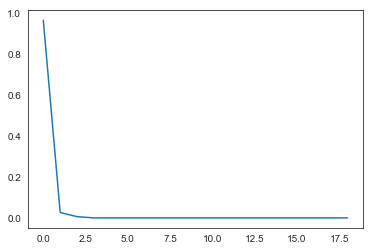

In [441]:
p_train_x = pd.read_csv("/Users/uriamor/Documents/TAU/Wavelet_Unis_2/db/parkinson/trainingData.txt", sep='\s', header=None)
p_train_y = pd.read_csv("/Users/uriamor/Documents/TAU/Wavelet_Unis_2/db/parkinson/trainingLabel.txt", sep=',', header=None, index_col=None)
# p_train_x = np.log1p(p_train_x - p_train_x.min())
park_pca = PCA().fit(p_train_x-p_train_x.mean())
plt.plot(np.arange(0, park_pca.n_features_), park_pca.explained_variance_ratio_)
p_train_x_pca = park_pca.transform(p_train_x-p_train_x.mean())[:,[0,1]]

# PCA parkinson

(5875, 2)
66.07396954958689
	64.0953436396224
	67.74147645459183


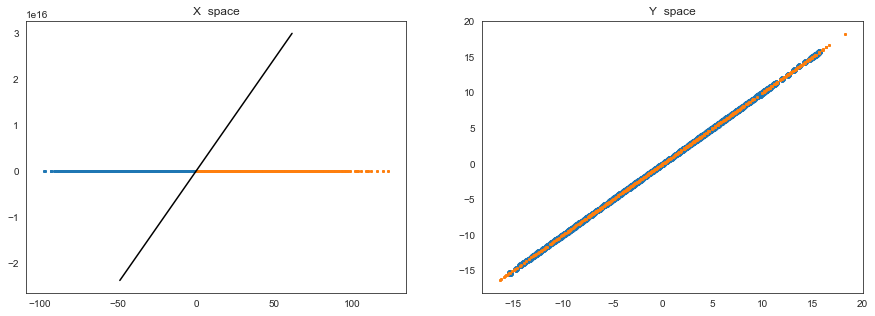

(2966, 2)
64.0953436396224
	46.800259994375004
	63.98280344643569


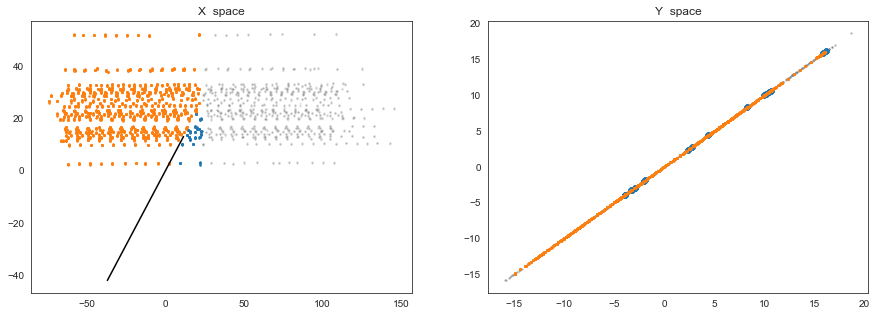

(120, 2)
46.800259994375004
	30.909606187499993
	50.66673545996093


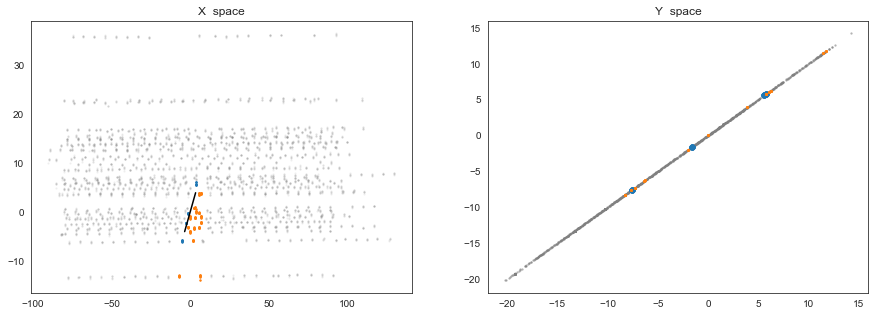

In [442]:
X_orig,Y_orig = p_train_x_pca.copy(),p_train_y.values.copy()
X_orig,Y_orig = X_orig- X_orig.mean(),Y_orig- Y_orig.mean()
X, Y = X_orig.copy() ,Y_orig.copy() 

acc_mean_x = np.zeros(X.shape[1])
acc_mean_y = np.zeros(Y.shape[1])

pca = PCA()

def var_objective(f_space, r_space, plane_eq):
    bias = plane_eq[-1]
    plane = plane_eq[:-1]
    labels = (f_space@plane <= bias)
    res_A = r_space[labels]
    res_B = r_space[np.logical_not(labels)]
    return np.var(res_A) + np.var(res_A) + 0.5*np.abs(np.log2( (1e-4 + res_A.shape[0])/(1e-4 + res_B.shape[0]) ))

i = 0
while X.shape[0] > 30:
    print(X.shape)
    print(Y.var())
    i+=1
    
    pcaf = pca.fit(X)
    var_cost = lambda plane:  var_objective(X,Y,plane)
    opt_var = np.inf
    bi = None
    thetas = None
    
    for i in range(min(X.shape)):
        start_point = np.zeros([min(X.shape) + 1])
        start_point[i] += 1
        start_point[:min(X.shape)] = pcaf.inverse_transform(start_point[:-1])
        res = minimize(var_cost, start_point, method='Nelder-Mead')
        if res.fun < opt_var:
            opt_var = res.fun
#             print(res.fun)
            bi = res.x[-1]
            thetas = res.x[:-1]
    
    
    next_g = (X@thetas - bi <= 0 )
    
    
    plt.figure(figsize=[15, 5])
    
    # plot x space
    plt.subplot(121)
    plt.scatter(X_orig[:,0],X_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(X[next_g,0],X[next_g ,1], s = 2)
    plt.scatter(X[np.logical_not(next_g) ,0],X[np.logical_not(next_g)  ,1], s = 2)
    plt.title('X  space')
    
    #     plot hyper plane 
    
    if thetas[1] != 0:
        x0, x1 = X[:,0].min()*.5, X[:,0].max()*.5
        y0,y1 =  -(x0*thetas[0]-bi)/thetas[1] ,  - (x1*thetas[0]-bi)/thetas[1] 
    else:
        y0,y1 =  X_orig[:,1].min()*.7, X_orig[:,1].max()*.76
        x0, x1 = -(y0*thetas[1]-bi)/thetas[0] ,  - (y1*thetas[1]-bi)/thetas[0] 
    plt.plot([x0, x1],[y0, y1], 3,c='k')

    # plot y space
    plt.subplot(122)
    plt.scatter(Y_orig[:,0],Y_orig[:,0], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(Y[next_g ,0],Y[next_g  ,0], s = 25)
    plt.scatter(Y[np.logical_not(next_g),0],Y[np.logical_not(next_g) ,0], s = 2)
    print("\t{}".format(Y[next_g ,0].var()))
    print("\t{}".format(Y[np.logical_not(next_g) ,0].var()))
    plt.title('Y  space')
    plt.show()


    # reduce to other hyperplane
    X = X[next_g]
    Y = Y[next_g]
    
    # accomulated shift
    acc_mean_x -=  X.mean()
    acc_mean_y -=  Y.mean()
    
    # center by mean
    X_orig -=  X.mean()
    Y_orig -=  Y.mean()
    
    X -=  X.mean()
    Y -=  Y.mean()

# pls parkinson

1.0000000000000002
	0.9071715418052998
	0.9944123255480045


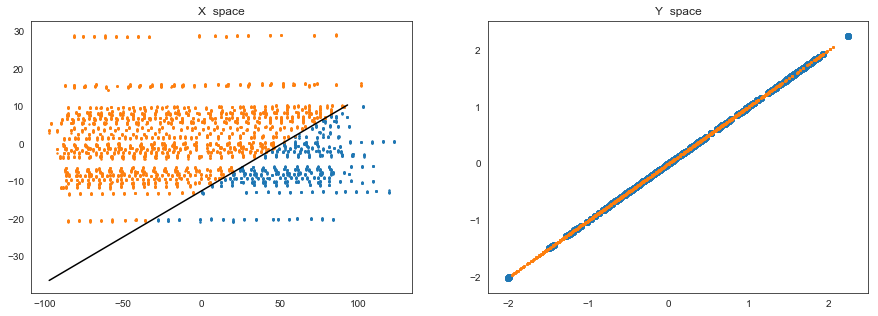

0.9071715418052998
	0.6331625968505125
	0.9876199731025006


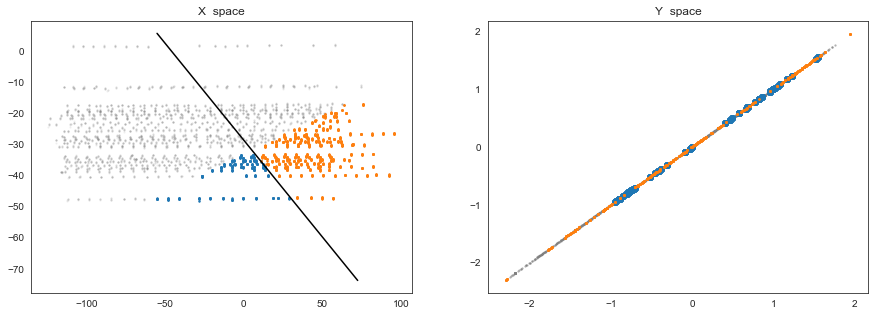

0.6331625968505125
	0.2247093967163723
	0.6250059187134076


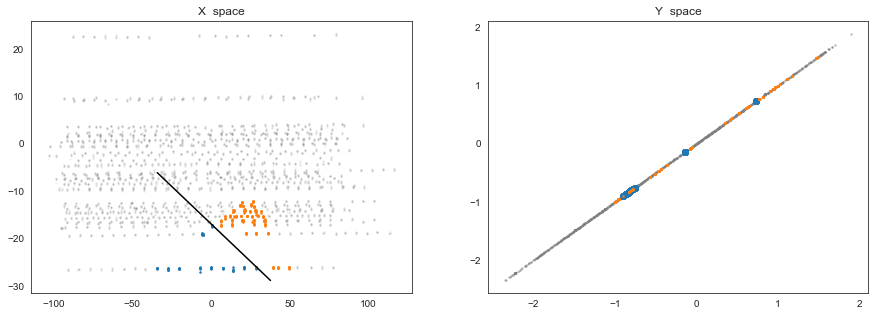

0.22470939671637227
	0.0017869958599352855
	0.264525771812773


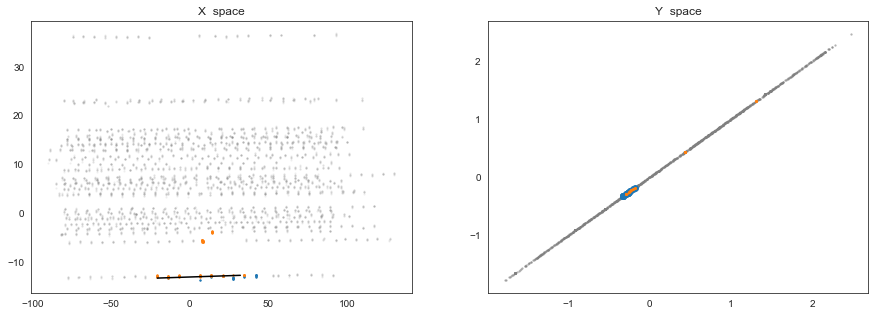

In [443]:
X_orig,Y_orig = p_train_x_pca.copy(),p_train_y.values.copy()
X_orig,Y_orig = X_orig- X_orig.mean(),Y_orig- Y_orig.mean()
Y_orig = Y_orig/Y_orig.std()
X, Y = X_orig.copy() ,Y_orig.copy() 

acc_mean_x = np.zeros(X.shape[1])
acc_mean_y = np.zeros(Y.shape[1])

pls= PLSRegression(n_components=2)

i = 0
while X.shape[0] > 50:
    print(Y.var())
    i+=1
    
    plsf = pls.fit(X,Y)
    rot=plsf.x_weights_[:,0]
    
    scores = np.sort(X@rot)
    scores_gaps = (scores[1:] + scores[:-1] )/2
    next_g = (X@rot <= scores_gaps[0])
    sc_cnt = 0
    cnt_min = 0
    part_error = np.abs(np.log2(0.001 +next_g.sum() / (0.001 +np.logical_not(next_g).sum())))
    min_part_err = np.inf
    
    while part_error >1.75 and sc_cnt < scores_gaps.shape[0]:
        
        next_g = (X@rot <= scores_gaps[sc_cnt])
        part_error = np.abs(np.log2(0.0001 +next_g.sum() / (0.0001 +(~next_g).sum())))
        if part_error < min_part_err:
            min_part_err = part_error
            cnt_min = sc_cnt
        sc_cnt +=1
        
    next_g = (X@rot <= scores_gaps[cnt_min])
    

    
    plt.figure(figsize=[15, 5])
    
    # plot x space
    plt.subplot(121)
    plt.scatter(X_orig[:,0],X_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(X[next_g,0],X[next_g ,1], s = 2)
    plt.scatter(X[np.logical_not(next_g) ,0],X[np.logical_not(next_g)  ,1], s = 2)
    plt.title('X  space')
    
    #     plot hyper plane 
    x0, x1 = X[:,0].min(), X[:,0].max()*.76
    y0,y1 = -(x0*rot[0]- scores_gaps[cnt_min])/rot[1] , -(x1*rot[0]- scores_gaps[cnt_min])/rot[1] 
    plt.plot([x0, x1],[y0, y1], 3,c='k')

    # plot y space
    # plot y space
    plt.subplot(122)
    plt.scatter(Y_orig[:,0],Y_orig[:,0], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(Y[next_g ,0],Y[next_g  ,0], s = 35)
    plt.scatter(Y[np.logical_not(next_g),0],Y[np.logical_not(next_g) ,0], s = 2)
    plt.title('Y  space')
    print("\t{}".format(Y[next_g ,0].var()))
    print("\t{}".format(Y[np.logical_not(next_g) ,0].var()))
    
    plt.show()


    # reduce to other hyperplane
    X = X[next_g]
    Y = Y[next_g]
    
    # accomulated shift
    acc_mean_x -= X.mean()
    acc_mean_y -= Y.mean()
    
    # center by mean
    X_orig -= X.mean()
    Y_orig -= Y.mean()
    
    X -= X.mean()
    Y -= Y.mean()

# svm parkinson

(5875, 2)


/Users/uriamor/anaconda/envs/WF/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


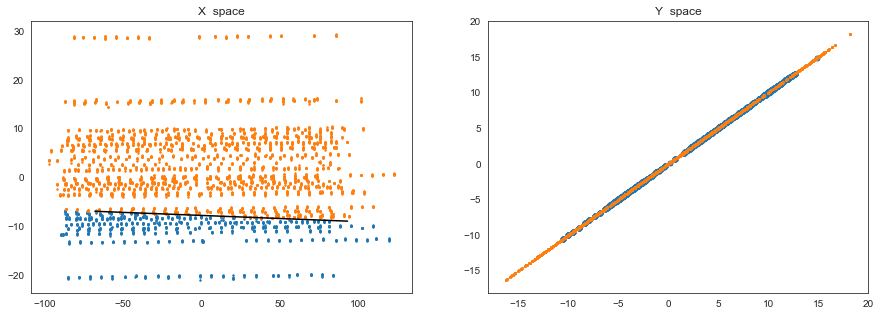

(1347, 2)


/Users/uriamor/anaconda/envs/WF/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


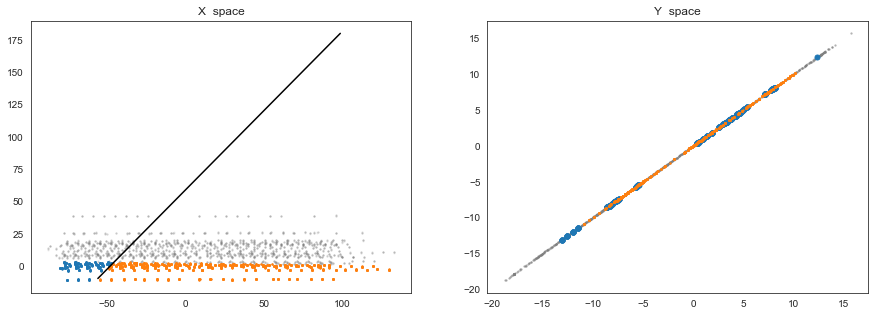

(309, 2)


/Users/uriamor/anaconda/envs/WF/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


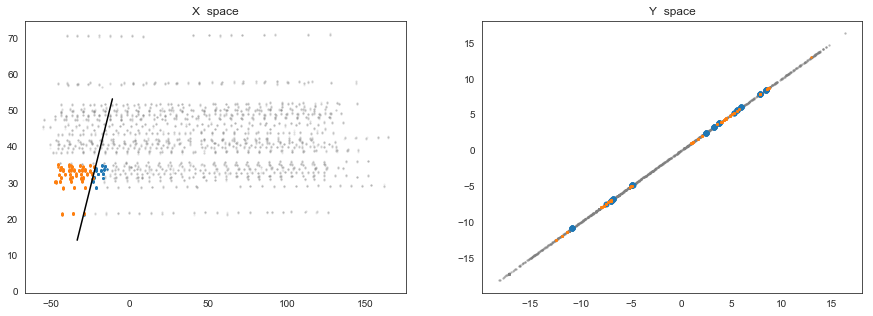

In [411]:
from sklearn.svm import SVC
from sklearn.cluster import KMeans


X_orig,Y_orig = p_train_x_pca.copy(),p_train_y.values.copy()
X_orig,Y_orig = X_orig- X_orig.mean(),Y_orig- Y_orig.mean()


X, Y = X_orig.copy() ,Y_orig.copy() 

acc_mean_x = np.zeros(X.shape[1])
acc_mean_y = np.zeros(Y.shape[1])

km = KMeans(n_clusters=2, tol=1e-3, max_iter=450,n_init=5,algorithm='full', random_state=1203)
sv= SVC( kernel='linear', max_iter=2000,tol = 1e-3,random_state=10023)

i = 0
while X.shape[0] > 300:
    print(X.shape)
    i+=1
    
    kmf = km.fit(Y)
    labels_X = kmf.predict(Y)

    svf = sv.fit(X, labels_X)
    rot = svf.coef_[0] / np.linalg.norm(svf.coef_[0])
    scores = np.sort(X@rot)
    scores_gaps = (scores[1:] + scores[:-1] )/2
    next_g = (X@rot <= scores_gaps[0])
    sc_cnt = 0
    cnt_min = 0
    part_error = np.abs(np.log2(0.001 +next_g.sum() / (0.001 +np.logical_not(next_g).sum())))
    min_part_err = np.inf
    
    while part_error >1.75 and sc_cnt < scores_gaps.shape[0]:
        
        next_g = (X@rot <= scores_gaps[sc_cnt])
        part_error = np.abs(np.log2(0.0001 +next_g.sum() / (0.0001 +(~next_g).sum())))
        if part_error < min_part_err:
            min_part_err = part_error
            cnt_min = sc_cnt
        sc_cnt +=1
        
    next_g = (X@rot <= scores_gaps[cnt_min])
    
#     next_g = (X@svf.coef_[0] - svf.intercept_[0] <= 0 )
    
    
    plt.figure(figsize=[15, 5])
    
    # plot x space
    plt.subplot(121)
    plt.scatter(X_orig[:,0],X_orig[:,1], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(X[next_g,0],X[next_g ,1], s = 2)
    plt.scatter(X[np.logical_not(next_g) ,0],X[np.logical_not(next_g)  ,1], s = 2)
    plt.title('X  space')
    
    #     plot hyper plane 
    x0, x1 = X[:,0].min()*.7, X[:,0].max()*.76
    y0,y1 =  -(x0*rot[0]-scores_gaps[cnt_min])/rot[1] ,  - (x1*rot[0]-scores_gaps[cnt_min])/rot[1]
    plt.plot([x0, x1],[y0, y1], 3,c='k')

    # plot y space
    plt.subplot(122)
    plt.scatter(Y_orig[:,0],Y_orig[:,0], s = 2,c = 'gray', alpha=0.07)
    plt.scatter(Y[next_g ,0],Y[next_g  ,0], s = 25)
    plt.scatter(Y[np.logical_not(next_g),0],Y[np.logical_not(next_g) ,0], s = 2)
    plt.title('Y  space')
    plt.show()


    # reduce to other hyperplane
    X = X[next_g]
    Y = Y[next_g]
    
    # accomulated shift
    acc_mean_x -=  X.mean()
    acc_mean_y -=  Y.mean()
    
    # center by mean
    X_orig -=  X.mean()
    Y_orig -=  Y.mean()
    
    X -=  X.mean()
    Y -=  Y.mean()